# Weighted Max-Cut with QAOA

## Brief Problem Description

The problem of interest is the weighted max cut problem. Given a set of vertices and weighted edges connecting some of the vertices, we are interested in separating the vertices into two sets such that the sum of the weights of the edges between the sets is maximized. 

## QAOA Description and Value of P

QAOA works in two stages: a classical stage and a quantum computing stage (see below).

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import sys
import pandas as pd
import Qconfig
from tqdm import tqdm
from random import randint, choice, uniform
from math import ceil
from statistics import stdev, mean
from skopt import gbrt_minimize, dummy_minimize, forest_minimize, gp_minimize
from qiskit import register, available_backends, QuantumCircuit, QuantumRegister, \
        ClassicalRegister, execute

register(Qconfig.APItoken, Qconfig.config["url"])
pbar = None
DEBUG = False

def debug(string):
    if DEBUG:
        sys.stdout.write(string)
        sys.stdout.flush()

/Users/raghavan/Documents/Sem3/FRI/venv/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Classical Stage:

In the classical stage, two parameters gamma and beta are randomly chosen and fed into the quantum computer. The quantum computer returns an expectation value to the classical computer based on those two parameters. Based on what expectation values it has seen and what it has now, the classical computer alters the parameters to optimize the cost function in aim for a minimum expectation value. This repeats until the classical computer reaches a local minimum.

In [2]:
#TODO: remove this, we're not using this code to optimize anymore
def run_optimizer(num_nodes, filename="results.csv"):
    debug("-- Building Graph--\n")
    g = Graph(num_nodes)
    debug(str(g) + "\n")

    best, best_val = g.optimal_score()
    debug("Optimal Solution: %s, %s\n" % (best, best_val[0]))

    # Initialize and run the algorithm.
    gamma_start = uniform(0, 2*np.pi)
    beta_start = uniform(0, np.pi)

    # minimize wants lower values, so negate expectation.
    neg_get_expectatation = lambda x, y: -1 * get_expectation(x, y)

    debug("\n-- Starting optimization --\n")
    try:
        res = minimize(neg_get_expectation, [gamma_start, beta_start], args=(g),
                options=dict(maxiter=2,disp=True), bounds=[(0, 2*np.pi), (0,np.pi)])
    except KeyboardInterrupt:
        debug("\nWriting to %s\n" % (filename))
        g.save_results(filename)
    finally:
        exit()

    debug("-- Finished optimization  --\n")
    debug("Gamma: %s, Beta: %s\n" % (res.x[0], res.x[1]))
    debug("Final cost: %s\n" % (res.maxcv))

    best, best_val = g.optimal_score()
    debug("Optimal Solution: %s, %s\n" % (best, best_val[0]))
    debug("Best Found Solution: %s, %s\n" % (g.currentScore, g.currentBest))

    debug("\nWriting to %s\n" % (filename))
    g.save_results(filename)


### Quantum Stage:

In this stage, p + 1 qubits are made based on the parameters gamma and beta along with the cost and driver hamiltonians W and V described below. The qubits are constructed like so: WpVp....W1V1 |Φ>. Where |Φ> is initially p input qubits in the + state and 1 output qubit in the 0 state. To measure the expectation with respect to the cost operator, all the input qubits should be measured and then the probabilities of each state recorded. The weighted average or expectation can then be computed by summing up state probabilities multiplied with state costs like so:
```
C = P(state ‘000..0’) * cost(‘000..0’) + … + P(state ‘111..1’) * cost(‘111..1’)
```



## Methods

### Problem Encoding:

Given a graph with V vertices and E edges, we could encode a candidate solution as a V-length bitstring, where each bit corresponds to which cut the corresponding node in the graph belongs to. To evaluate cost, we simply iterate through the edges in the graph and, for nodes belonging to different cuts in the given bitstring, we sum the weights of their edges.


In [3]:
class Graph():
    def __init__(self, N, randomize=True):
        ''' Initialize a random graph with N vertices. '''
        self.N = N
        self.E = 0
        self.adj = {n:dict() for n in range(N)}

        # For storing information about each run.
        self.currentScore = float('-inf')
        self.currentBest = ""
        self.runs = []

        # Randomly generate edges
        if randomize:
            self.randomize()

    def randomize(self):
        ''' Randomly generate edges for this graph. '''

        # Generate list of tuples for all possible directed edges.
        all_possible_edges = set([(x,y) for x in range(self.N) for y in range(self.N) if x != y])

        # Sanity check, ensuring we generated the correct number of edges.
        e_gen = len(all_possible_edges) / 2
        e_shd = self.N * (self.N-1) / 2
        assert e_gen == e_shd , "%d != %d" % (e_gen, e_shd)

        # Choose a random number of edges for this graph to have. 
        # Note, we stop at len/2 because we generated directed edges,
        # so each edge counts twice.
        num_edges = randint(1, len(all_possible_edges)/2)
        for i in range(num_edges):
            # Choose an edge, remove it and its directed complement from the list.
            e = choice(list(all_possible_edges))
            all_possible_edges.remove(e)
            all_possible_edges.remove(e[::-1])

            # Unpack tuple into vertex ints.
            u, v = int(e[0]), int(e[1])

            # Choose a random weight for each edge.
            weight = randint(1, 100)

            #weight = 1
            self.add_edge(u, v, weight)


    def add_edge(self, u, v, weight):
        ''' Add an edge to the graph. '''
        self.E += 1
        self.adj[u][v] = weight

    def get_edges(self):
        ''' Get a list of all edges. '''
        edges = []
        for u in self.adj:
            for v in self.adj[u]:
                edges.append((u, v, self.adj[u][v]))
        return edges

    def get_score(self,bitstring):
        ''' Score a candidate solution. '''
        assert len(bitstring) == self.N

        score = 0

        # For every edge u,v in the graph, add the weight
        # of the edge if u,v belong to different cuts
        # given this canddiate solution.

        for u in self.adj:
            for v in self.adj[u]:
                if bitstring[u] != bitstring[v]:
                    score += self.adj[u][v]
        return score

    def optimal_score(self):
        '''
        Returns (score, solutions) holding the best possible solution to the
        MaxCut problem with this graph.
        '''

        best = 0
        best_val = []

        # Iterate over all possible candidate bitstrings
        # Note: the bitstrings from 0 - N/2 are symmetrically
        # equivalent to those above
        for i in range(ceil((2 ** self.N)/2)):
            # Convert number to 0-padded bitstring.
            bitstring = bin(i)[2:]
            bitstring = (self.N - len(bitstring)) * "0" + bitstring

            sc = self.get_score(bitstring)
            if sc > best:
                best = sc
                best_val = [bitstring]
            elif sc == best:
                best_val.append(bitstring)
        return best, best_val

    def edges_cut(self, bitstring):
        ''' Given a candidate solution, return the number of edges that this solution cuts. '''
        num = 0
        for u in self.adj:
            for v in self.adj[u]:
                if bitstring[u] != bitstring[v]:
                    num += 1
        return num

    def update_score(self, bitstring):
        ''' Scores the given bitstring and keeps track of best. '''
        score = self.get_score(bitstring)
        if score > self.currentScore:
            self.currentScore = score
            self.currentBest = bitstring
        return score
    
    def clear_runs(self):
        ''' Clear data from past runs. '''
        self.currentScore = float('-inf')
        self.currentBest = ""
        self.runs = []
        
    def add_run(self, gamma, beta, expected_value):
        ''' Save the data from each run iteration. '''
        self.runs.append([gamma, beta, expected_value])
        
    def __str__(self):
        return "Graph with %d vertices %d edges.\nAdjacency List: %s" % (self.N, self.E, self.adj)

#graph encoding sample 
g = Graph(5)
print(g)

Graph with 5 vertices 9 edges.
Adjacency List: {0: {4: 86, 2: 88, 3: 72}, 1: {4: 48, 2: 6}, 2: {3: 7}, 3: {1: 83, 4: 29}, 4: {2: 66}}


### Cost and Driver Hamiltonians C and B:

The cost hamiltonian V can be expressed by exp(-i x gamma x C), where C is the cost operator that transforms a qubit state |Φ> to C(x1,x1,..xp) * |Φ>. In the case of weighted max cut, we can express the cost operator as a sum of local cost operators which each corresponding to an edge in the graph. For each of the qubits corresponding to the vertices of that edge, we apply a phase of e^(i*w*gamma), where w is the weight of the edge between those two qubits.

The driver hamiltonian W can be expressed by exp(-i x beta x B), where B is the an operator that flips all the input qubits (X gate on all p input qubits). 

In [4]:
def get_expectation(x, g, NUM_SHOTS=1024):
    # Look for progress bar as a global variable.
    global pbar
    
    gamma, beta = x

    debug("Cost of Gamma: %s, beta: %s... " % (gamma, beta))

    # Construct quantum circuit.
    q = QuantumRegister(g.N)
    c = ClassicalRegister(g.N)
    qc = QuantumCircuit(q, c)

    # Apply hadamard to all inputs.
    for i in range(g.N):
        qc.h(q[i])

    # Apply V for all edges.
    for edge in g.get_edges():
        u, v, w = edge

        # Apply CNots.
        qc.cx(q[u], q[v])

        qc.u1(gamma*w, q[v])

        # Apply CNots.
        qc.cx(q[u], q[v])

    # Apply W to all vertices.
    for i in range(g.N):
        qc.h(q[i])
        qc.u1(-2*beta, q[i])
        qc.h(q[i])


    # Measure the qubits (avoiding ancilla).
    for i in range(g.N):
        qc.measure(q[i], c[i])

    # Run the simluator.
    job = execute(qc, backend='ibmq_qasm_simulator', shots=NUM_SHOTS)
    results = job.result()
    result_dict = results.get_counts(qc)

    debug("done!\n")

    # Calculate the expected value of the candidate bitstrings.
    exp = 0
    for bitstring in result_dict:
        prob = np.float(result_dict[bitstring]) / NUM_SHOTS
        score = g.update_score(bitstring)

        # Expected value is the score of each bitstring times
        # probability of it occuring.
        exp += score * prob

    debug("\tExpected Value: %s\n" % (exp))
    debug("\tBest Found Solution: %s, %s\n" % (g.currentScore, g.currentBest))

    g.add_run(gamma, beta, exp)

    # Try updating progress bar if defined.
    try:
        pbar.update(1)
    except:
        pass
    
    return exp # bc we want to minimize


# Statistics (we performed some tests and plotted graphs to verify our choices)

## Expectation vs Gamma and Beta:

We want to make sure there's actually a gradient, so we plotted how expectation changed with changing gamma and beta.
Here's the code for it plus the actual graphs. 



100%|██████████| 9/9 [01:07<00:00,  7.53s/it]No handles with labels found to put in legend.


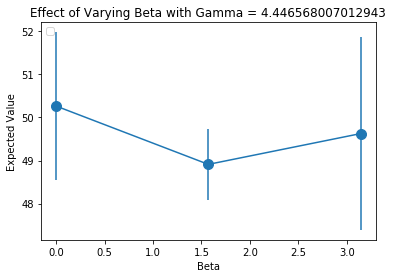

In [5]:
def hold_constant(vary="beta"):
    ''' Plots expected value vs. gamma/beta, holding the rest of the variables constant.'''
    # Choose some random starting beta/gamma and graph.
    lim = np.pi if vary == "gamma" else 2*np.pi
    constant_var = uniform(0, lim)
    g = Graph(5)

    # RUNS # of runs at each gamma for error bars.
    RUNS = 3

    # Keep track of gammas, expected values, for plotting.
    pts, exp, std = [], [], []

    # The maximum possible expected value is the maximum possible weighted cut.
    opt = g.optimal_score()[0]
    debug("Optimal score: %s\n" % (opt))
    
    # Number of data points to collect.
    NUM_RUNS = 3
    MIN = 0
    MAX = 2*np.pi if vary == "gamma" else np.pi
    
    # For progress bar.
    global pbar
    pbar = tqdm(total=NUM_RUNS*RUNS)
    
    points = np.linspace(MIN, MAX, NUM_RUNS)
    for point in points:
        pts.append(point)

        # Calculate expected values.
        vals = []
        for i in range(RUNS):
        
            # Params are passed in as gamma, beta, so order matters.
            params = [point, constant_var] if vary == "gamma" else [constant_var, point]
            vals.append(get_expectation(params, g))

        # Calculate mean, standard deviation.
        exp.append(mean(vals))
        std.append(stdev(vals))


    fig, ax = plt.subplots()

    ax.errorbar(x=pts, y=exp, yerr=std, fmt='o-', markersize=10)
    ax.legend(loc=2)

    # Names for plotting.
    vary_name = "Gamma" if vary == "gamma" else "Beta"
    const_name = "Beta" if vary_name == "Gamma" else "Gamma"
    
    ax.set_title("Effect of Varying %s with %s = %s" % (vary_name, const_name, constant_var))
    ax.set_xlabel("%s" % (vary_name)) 
    ax.set_ylabel("Expected Value")


    plt.show()
#hold_constant()

![gamma vs. exp](img/gamma_change.png)
![beta vs.exp](img/beta_change.png)
![beta vs.exp](img/gamma_test.png)

## Comparing Classical Optimizers:

Still not convinced we can actually optimize, we tested a bunch of different things:
    * graph size 15
    * n calls 8
    * 2 restarts
Below is the code to do the stuff followed by the results:

In [6]:
# Plot different types of optimizers.
def compare_optimizers(num_instances=4, graph_size=15, n_calls=8, n_random_starts=2):
    global pbar
    pbar = None
    
    # For progress bar.
    pbar = tqdm(total=num_instances*n_calls*4)
    
    instances = [Graph(graph_size) for _ in range(num_instances)]
    
    # Percent of optimal score acheived by each algorithm.
    dummy = []
    decision_trees = []
    gradient_boosted_trees = []
    baynesian = []
    
    # For each instance, run each algorithm.
    for inst in instances:
        # Scikit functions only take in parameters and want to minimize values.
        # Create a wrapper function to format get_expectation.
        sk_get_exp = lambda x: -1*get_expectation(x, inst)

        
        opt = inst.optimal_score()[0]
        
        # Dummy.
        inst.clear_runs()
        dummy_minimize(func=sk_get_exp,
                      dimensions=[(0,2*np.pi),(0,np.pi)],
                      n_calls=n_calls)
        dummy.append(float(inst.currentScore) / opt)

        # Decision Trees.
        inst.clear_runs()
        forest_minimize(func=sk_get_exp,
                      dimensions=[(0,2*np.pi),(0,np.pi)],
                      n_calls=n_calls,
                      n_random_starts=n_random_starts)
        decision_trees.append(float(inst.currentScore) / opt)
        
        # Gradient Boosted Decision Trees.
        inst.clear_runs()
        gbrt_minimize(func=sk_get_exp,
                      dimensions=[(0,2*np.pi),(0,np.pi)],
                      n_calls=n_calls,
                      n_random_starts=n_random_starts)
        gradient_boosted_trees.append(float(inst.currentScore) / opt)
        
        # Baynesian.
        inst.clear_runs()
        gp_minimize(func=sk_get_exp,
                      dimensions=[(0,2*np.pi),(0,np.pi)],
                      n_calls=n_calls,
                      n_random_starts=n_random_starts)
        baynesian.append(float(inst.currentScore) / opt)

    # Compare mean/stdev of % opt. achieved for each algorithm.
    print("-- % of Optimal Achieved, Mean and Std. Dev --")
    print("Random Sampling:\nMean: %s\nStd. Dev: %s" % (mean(dummy), stdev(dummy)))
    print("Decision Trees:\nMean: %s\nStd. Dev: %s" % (mean(decision_trees), stdev(decision_trees)))
    print("Gradient Boosted Decision Trees:\nMean: %s\nStd. Dev: %s" % (mean(gradient_boosted_trees), stdev(gradient_boosted_trees)))
    print("Baynesian Optimization:\nMean: %s\nStd. Dev: %s" % (mean(baynesian), stdev(baynesian)))
    
#compare_optimizers()

# Results

```
-- % of Optimal Achieved, Mean and Std. Dev --
Random Sampling:
    Mean: 0.9918135656630878
    Std. Dev: 0.008893516482779347
Decision Trees:
    Mean: 0.9911853052336336
    Std. Dev: 0.013767350119746134
Gradient Boosted Decision Trees:
    Mean: 0.9874128354367063
    Std. Dev: 0.01234703421622558
Baynesian Optimization:
    Mean: 0.9976966107272129
    Std. Dev: 0.00398958725007638
```

# woah
they're like really like close togetherl ike wooooah so should we even bother optimizng 
baynesian optimization seems to do the best, but the results are so close, that it doesn't really seem to 

## Results and Discussion

### Minimum, Maximum and Mean Costs across Problem Instances

In [ ]:
def instance_cost(num_instances=20, num_vert=10, num_runs=5):
    '''
    For several random problem instances, plot the cost of the output state.
    Plot average, maximum and minimum cost.
    '''

    # Prepare several random instances of the problem.
    instances = [Graph(num_vert) for _ in range(num_instances)]

    # Choose starting values for gamma and beta.

    # For holding iteration number and expected values.
    its, exps, opts, best_founds = [], [], [], []

    it = 1
    # Calculate expected values.
    for graph in tqdm(instances):
        vals = []
        for _ in range(num_runs):
            # Use random gamma, beta for each run.
            gamma = uniform(0, 2*np.pi)
            beta = uniform(0, np.pi)

            vals.append(get_expectation([gamma, beta], graph))

        # Save results.
        its.append(it)
        exps.append(vals)
        curr_opt = graph.optimal_score()[0]
        opts.append(curr_opt)
        best_founds.append(float(graph.currentScore) / curr_opt)
        it += 1


    plt.title("Costs of Random Instances")
    plt.xlabel("Instance Iteration Number")
    plt.ylabel("Cost")

    '''abandoned avenue
    # Sort by optimal value just so it's pleasant to look at.
    #exps = [x for _,x in sorted(zip(opt,exps), key=lambda pair: pair[0])]
    #opt = sorted(opt)
    '''
    
    averages = [mean(ex)/opt for ex, opt in zip(exps, opts)]
    lows = [min(ex)/opt for ex, opt in zip(exps, opts)]
    highs = [max(ex)/opt for ex, opt in zip(exps, opts)]

    plt.plot(its, averages, color='blue', label='Average Cost %')
    plt.plot(its, lows, color='green', label='Minimum Cost %')
    plt.plot(its, highs, color='orange', label='Maximum Cost %')
    plt.plot(its, best_founds, color='red', label='Best Found Cost %')

    plt.legend()

    plt.show()

![Cost Variation vs. Instance Iteration](img/gamma_change.png)